# ML Model to predict the AWS Product

### Import the necessary libraries

In [22]:
import string
import re
import nltk
import pandas as pd
import csv

from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('names')
from nltk.corpus import stopwords
from nltk.corpus import names
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aruna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Aruna\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
pd.set_option('display.max_colwidth', 150)

In [24]:
'''df = pd.read_csv('C:\\Users\\Aruna\\Documents\\ACMS-IID\\input\\CleanEC2.csv')
df.shape

with open('C:\\Users\\Aruna\\Documents\\ACMS-IID\\input\\Clean.csv', 'a', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(0, 100000):
            writer.writerow([df['id'][i], df['label'][i], df['description'][i]])'''

"df = pd.read_csv('C:\\Users\\Aruna\\Documents\\ACMS-IID\\input\\CleanEC2.csv')\ndf.shape\n\nwith open('C:\\Users\\Aruna\\Documents\\ACMS-IID\\input\\Clean.csv', 'a', encoding='utf-8', newline='') as csvfile:\n    writer = csv.writer(csvfile)\n    for i in range(0, 100000):\n            writer.writerow([df['id'][i], df['label'][i], df['description'][i]])"

### (A) Read the CSV file

In [25]:
df = pd.read_csv('C:\\Users\\Aruna\\Documents\\ACMS-IID\\input\\clean-with-symbols.csv')
df['description'] = df['description'].apply(lambda x: " ".join(x for x in str(x).split()))
df.head(10)

,id,label,description
0,1737.0,Amazon SNS,sms failure delivery retrieval detailed sms log using service sms notification event failed sms get acknowledgment containing detailed log object ...
1,1736.0,Amazon SNS,messages coming multiple accounts single sms short code use simple notification service send transactional sms messages clients requested notifica...
2,1735.0,Amazon SNS,android fcm support unity plugin unity plug-in build android due use depricated gcm api awsunitygcmwrapper ever going update plug-in builds fcm an...
3,1734.0,Amazon SNS,otp message delivery issue facing issue otp message delivery production environment mix behavior 1. message getting delivered 2. message delivered...
4,1733.0,Amazon SNS,simulating message persistence using sqs evaluating messaging requirements integrate multiple applications single producer publishes messages mult...
5,1732.0,Amazon SNS,sms messages delivered trying send sms messages via quite messages sent number delivered enabled cloudwatch logging shows correct entries provider...
6,1731.0,Amazon SNS,sms delivery fails phone currently unreachable/unavailable started observing behaviour today used work last week sms deliveries including messages...
7,1730.0,Amazon SNS,budget alert message sample implementing receive message budget alert created billing panel find place web sample message looks like chance one me...
8,1730.0,Amazon SNS,page configure test event option select event teplate look topic notification create entire test message json format looks like records eventsourc...
9,1729.0,Amazon SNS,mobile push endpoints use default content instead apns recently diving mobile push api registered many ios clients correct topics node.js server s...


#### Check the spread of tags in the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267845 entries, 0 to 267844
Data columns (total 3 columns):
id             267843 non-null float64
label          267845 non-null object
description    267845 non-null object
dtypes: float64(1), object(2)
memory usage: 6.1+ MB


In [6]:
df['label'].describe()

count         267845
unique             8
top       Amazon EC2
freq          100000
Name: label, dtype: object

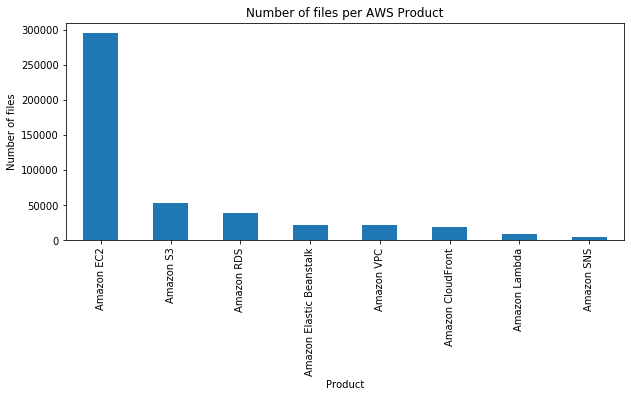

In [17]:
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');

plt.title("Number of files per AWS Product")
plt.xlabel("Product")
plt.ylabel("Number of files")
plt.savefig('foo.png', bbox_inches='tight', dpi=100)

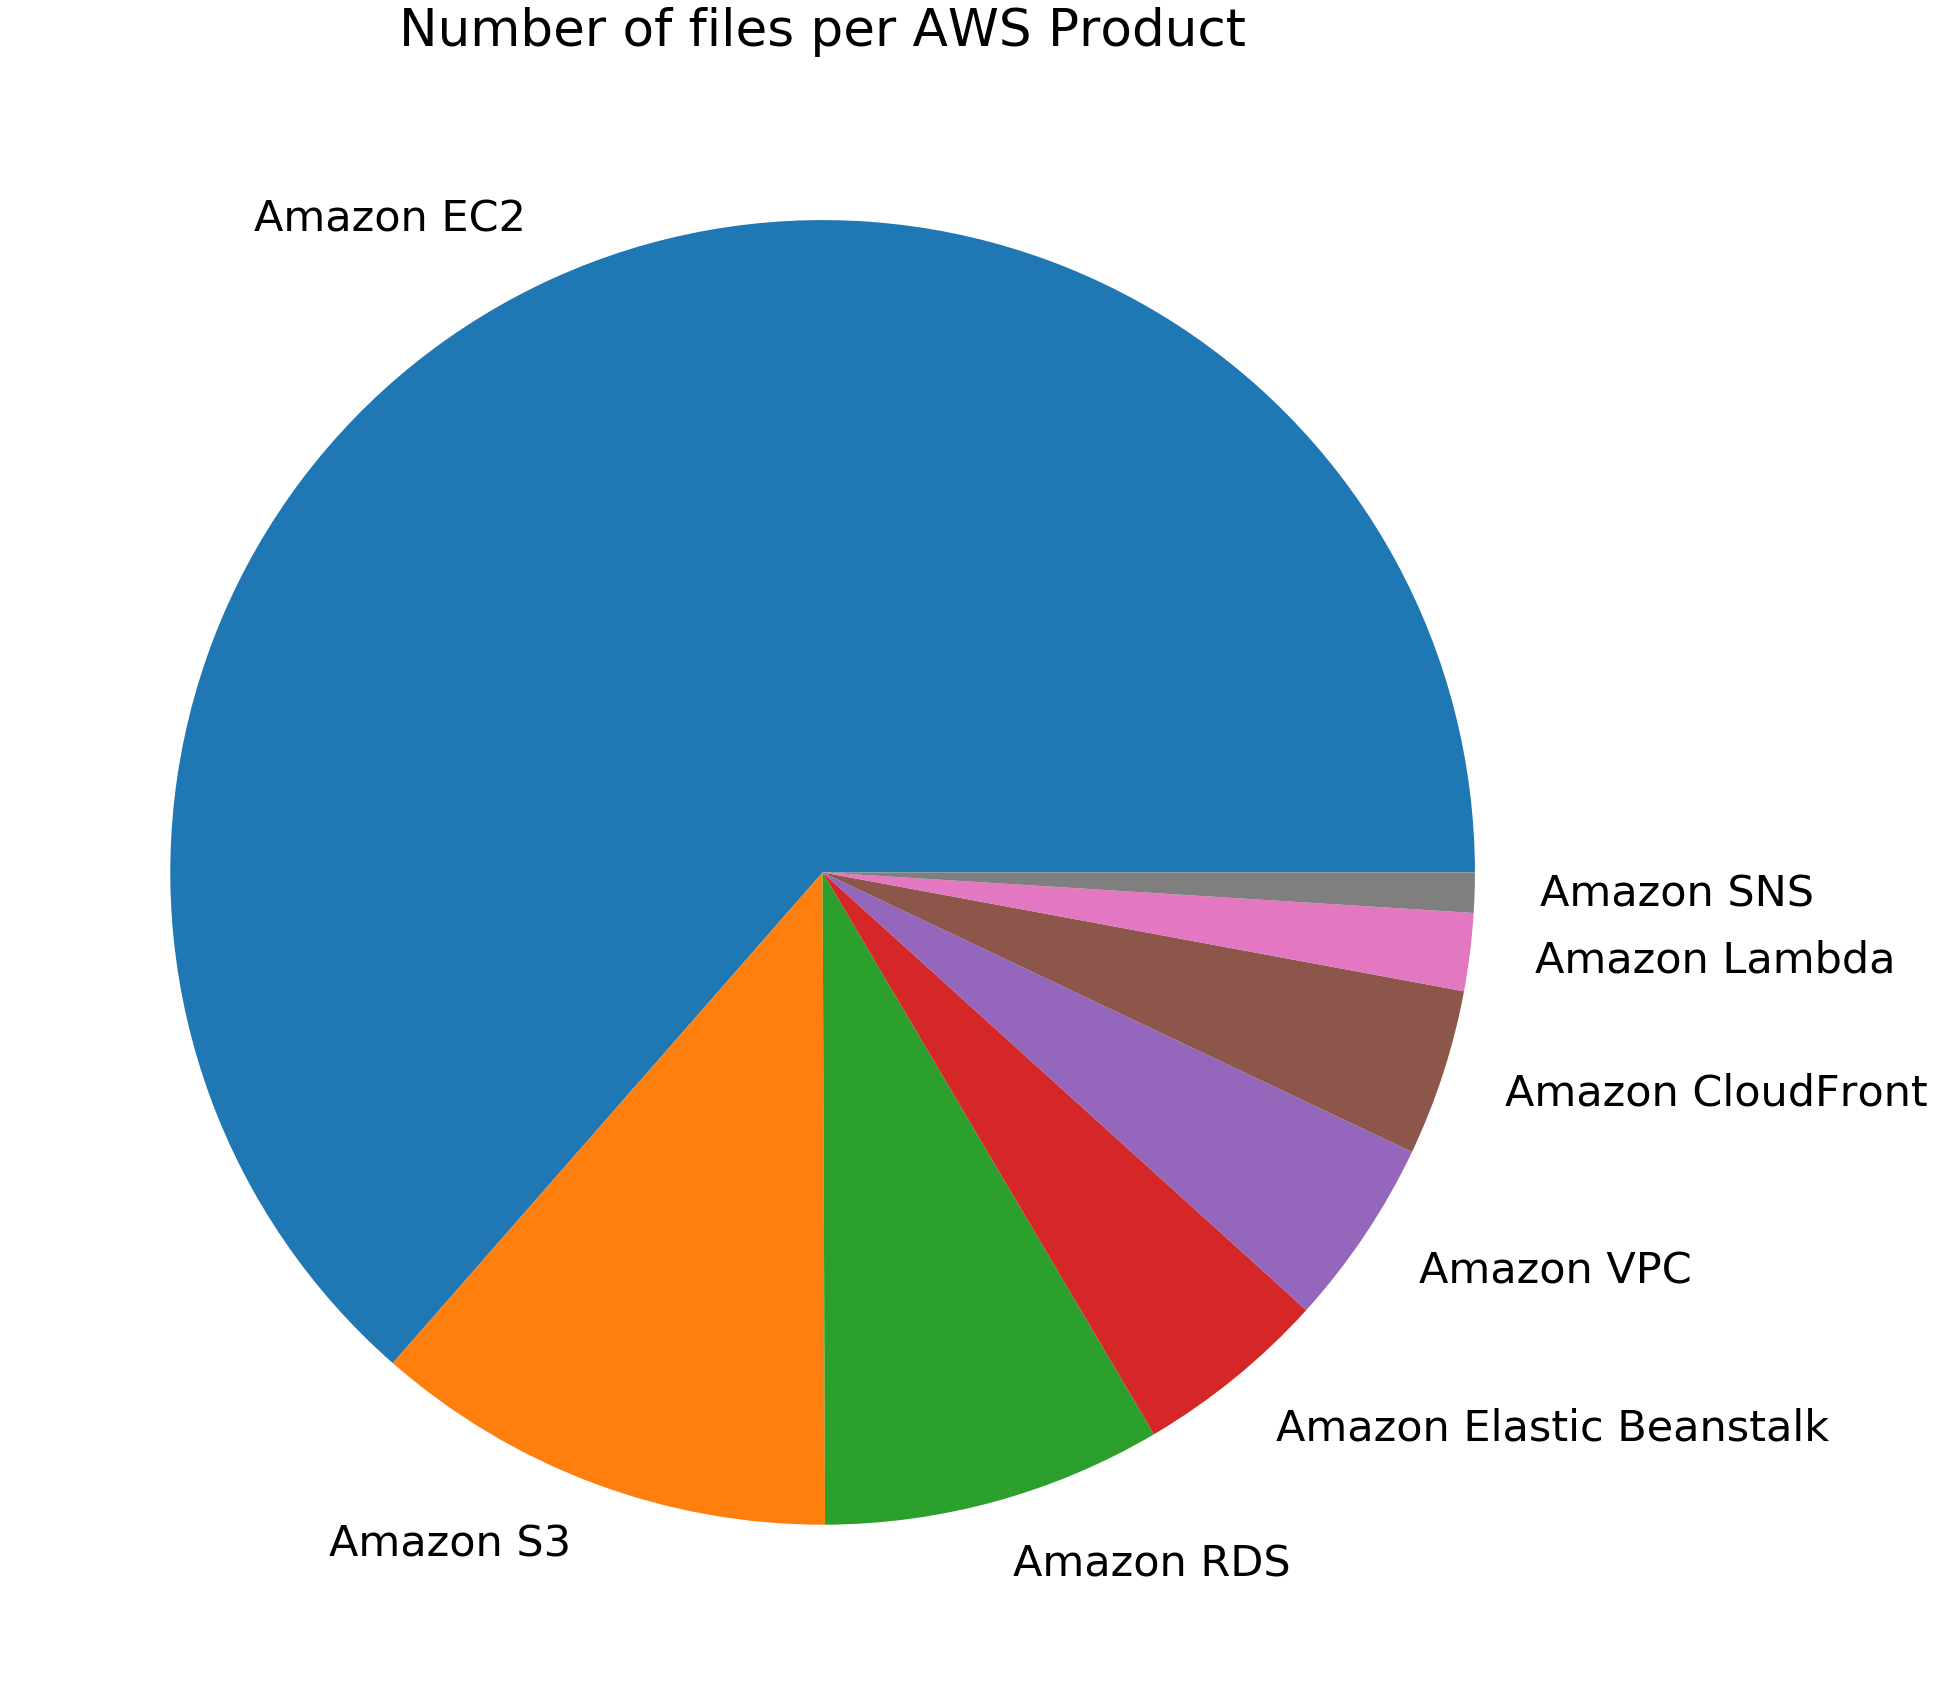

In [29]:
plt.rcParams.update({'font.size': 43})
plt.figure(figsize=(30, 30))
df.label.value_counts().plot(kind='pie');
plt.xlabel("")
plt.ylabel("")
plt.title("Number of files per AWS Product")
plt.savefig('foo.png', bbox_inches='tight', dpi=100)

#### Check out one sample post

In [8]:
df['description'][0]

'sms failure delivery retrieval detailed sms log using service sms notification event failed sms get acknowledgment containing detailed log object atleast providerresponse fix sms failure delivery failure reasons occurred delivery ttl expired quota left account unknown error attempting reach phone error log available console notification messageid exxxx8ad4bc55fe4ae28cdf8xxxx timestamp 46.913 delivery phonecarrier bharti airtel maharashtra mnc destination 9189xxxxxxxx priceinusd 0.00223 smstype transactional mcc providerresponse delivery ttl expired dwelltimems dwelltimemsuntildeviceack status failure present get based code snippet response service messageid d5212bf191835da4826e7e96a48xxxxx data.providerresponse undefined delivery undefined json.stringify responsemetadata requestid 5d9bxxx9319d52b48979xxxxxxxx messageid d521xxxxf191xx5da4826exxxxxxxx code snippet exports.sendsms function msg phonenumber phonenumber phonenumber setmessageattributes createsubscription phonenumber var par

#### Top 30 words + frequency of each:

In [9]:
freq = pd.Series(' '.join(df['description']).split()).value_counts()[:30]
freq

instance     188147
using         67516
error         60822
server        56111
get           52442
new           50759
use           50424
file          50169
issue         47550
instances     47097
one           45103
see           43075
bucket        41488
like          40908
time          39673
access        38629
problem       38230
ms            37878
need          37660
also          36311
running       36018
help          35346
set           32010
request       31944
data          31394
files         31209
create        29111
still         28503
security      25676
account       25433
dtype: int64

In [10]:
print("There are totally", df['description'].apply(lambda x: len(x.split(' '))).sum(), "words.")

There are totally 11118429 words.


### (B) Feature Engineering & Model Deployment

In [11]:
from sklearn.model_selection import train_test_split

X = df['description']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Naive Bayes Classifier for Multinomial Models

In [ ]:
nb = Pipeline([('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

nb.fit(X_train, y_train)

In [ ]:
predictions = nb.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print('accuracy:', accuracy_score(predictions, y_test))

## LogisticRegression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression(n_jobs = 1))])

logreg.fit(X_train, y_train)

In [ ]:
predictions = logreg.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print('accuracy:', accuracy_score(predictions, y_test))

## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', TfidfVectorizer()), ('clf', RandomForestClassifier())])

rf.fit(X_train, y_train)

In [ ]:
predictions = rf.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print('accuracy:', accuracy_score(predictions, y_test))

## Linear SVC Model

In [13]:
from sklearn.svm import LinearSVC

svm = Pipeline([('vect', TfidfVectorizer()), ('clf', LinearSVC())])

svm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [14]:
predictions = svm.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print('accuracy:', accuracy_score(predictions, y_test))

[[ 3612   717    49    45   120  1140    10    30]
 [  178 26613   484    69   851  1137    41   693]
 [   59  1475  4494    49   229   306    20    85]
 [   47   417   100  1691   105   240    28    43]
 [   44  1997   127    32  8892   368    13   121]
 [  461  1770   135    84   281 13133    32    54]
 [   16   225    32    20    34   122   919     8]
 [   28  1796    54    19   182   204    10  3964]]
                          precision    recall  f1-score   support

       Amazon CloudFront       0.81      0.63      0.71      5723
              Amazon EC2       0.76      0.89      0.82     30066
Amazon Elastic Beanstalk       0.82      0.67      0.74      6717
           Amazon Lambda       0.84      0.63      0.72      2671
              Amazon RDS       0.83      0.77      0.80     11594
               Amazon S3       0.79      0.82      0.81     15950
              Amazon SNS       0.86      0.67      0.75      1376
              Amazon VPC       0.79      0.63      0.70      6

## XGBoost Model

In [15]:
from xgboost import XGBClassifier

xgb = Pipeline([('vect', TfidfVectorizer()), ('clf', XGBClassifier())])
xgb.fit(X_train, y_train)

%time

Wall time: 0 ns


In [16]:
predictions = xgb.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print('accuracy:', accuracy_score(predictions, y_test))

[[ 2759  1998    21    28    10   886     1    20]
 [   47 27914   388    66   557   499    16   579]
 [   13  2976  3221    20   172   238     9    68]
 [   47  1097    69  1209    50   162    10    27]
 [    8  4653    93    52  6523   167     4    94]
 [  305  5720    74    87    91  9636     9    28]
 [    5   633    18    18    13    61   626     2]
 [    4  2708    56    13    83    61     0  3332]]
                          precision    recall  f1-score   support

       Amazon CloudFront       0.87      0.48      0.62      5723
              Amazon EC2       0.59      0.93      0.72     30066
Amazon Elastic Beanstalk       0.82      0.48      0.60      6717
           Amazon Lambda       0.81      0.45      0.58      2671
              Amazon RDS       0.87      0.56      0.68     11594
               Amazon S3       0.82      0.60      0.70     15950
              Amazon SNS       0.93      0.45      0.61      1376
              Amazon VPC       0.80      0.53      0.64      6